Loading data...
Preprocessing data...
Building the LSTM model...


C:\Users\sande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          47,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           2,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,472 (197.16 KB)

 Trainable params: 50,472 (197.16 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model...
Epoch 1/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9153 - loss: 0.6867 - val_accuracy: 0.9886 - val_loss: 0.0433
Epoch 2/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9907 - loss: 0.0388 - val_accuracy: 0.9925 - val_loss: 0.0302
Epoch 3/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9923 - loss: 0.0290 - val_accuracy: 0.9931 - val_loss: 0.0255
Epoch 4/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9929 - loss: 0.0240 - val_accuracy: 0.9932 - val_loss: 0.0219
Epoch 5/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9941 - loss: 0.0211 - val_accuracy: 0.9951 - val_loss: 0.0199
Epoch 6/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9941 - loss: 0.0197 - val_accuracy: 0.9945 - val_loss: 0.0188
Epoch 7/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9948 - loss: 0.0177 - val_accuracy: 0.9948 - val_loss: 0.0179
Epoch 8/10
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accur

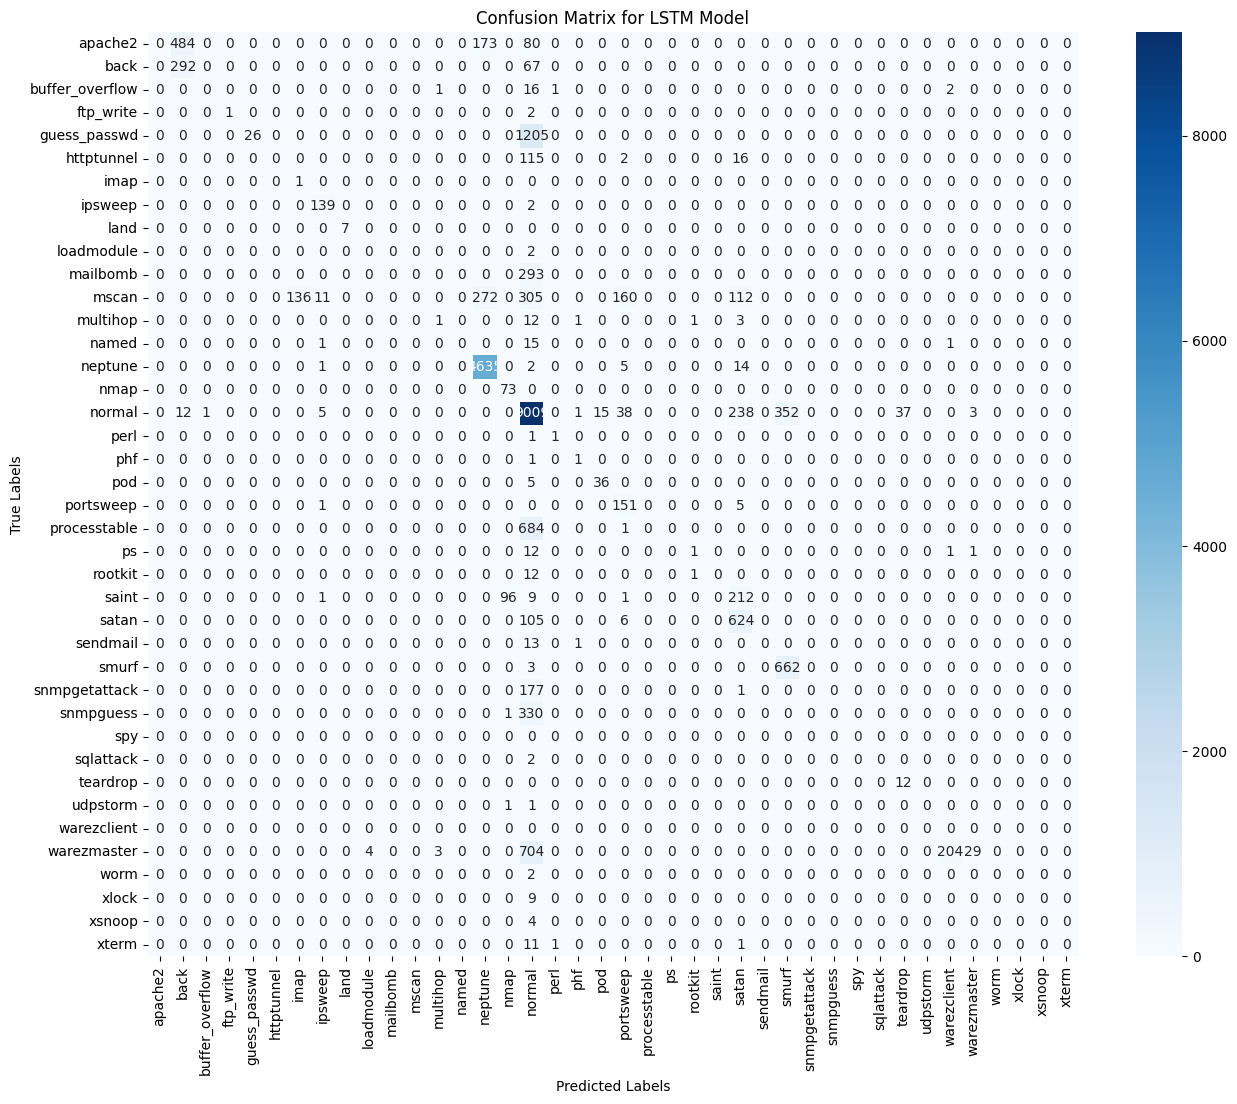

In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# This code assumes you have 'KDDTrain+.txt' and 'KDDTest+.txt' in the same folder.

# 2. Load the Training and Testing Datasets
col_names = [f"feature_{i}" for i in range(41)] + ['label', 'difficulty']
print("Loading data...")
train_df = pd.read_csv('KDDTrain+.txt', header=None, names=col_names)
test_df = pd.read_csv('KDDTest+.txt', header=None, names=col_names)

# 3. Prepare the Data
train_df = train_df.drop('difficulty', axis=1)
test_df = test_df.drop('difficulty', axis=1)

X_train = train_df.drop('label', axis=1)
y_train_str = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test_str = test_df['label']

# --- Preprocessing ---
print("Preprocessing data...")
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align columns
train_cols = X_train.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0
X_test = X_test[X_train.columns]

# Scale Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode Labels
all_labels = pd.concat([y_train_str, y_test_str])
le = LabelEncoder()
le.fit(all_labels)
y_train_encoded = le.transform(y_train_str)
y_test_encoded = le.transform(y_test_str)
num_classes = len(le.classes_)

# One-Hot Encode Labels for Keras
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# CRUCIAL: Reshape data for LSTM input -> (samples, timesteps, features)
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 4. Build and Compile the LSTM Model
print("Building the LSTM model...")
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Train the Model
print("\nTraining the LSTM model...")
model.fit(X_train_reshaped, y_train_categorical, epochs=10, batch_size=64, validation_split=0.1)
print("Model training complete.")

# 6. Make Predictions and Evaluate
print("Making predictions...")
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)

# 7. Print Final Reports
print("\n--- LSTM Model Performance ---")
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, labels=range(num_classes), zero_division=0))

print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test_encoded, y_pred, labels=range(num_classes))
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for LSTM Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Calculate the overall scores using the 'weighted' average ---

# This calculates the average precision, weighted by the number of samples in each class.
overall_precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

# This calculates the average recall, weighted by the number of samples in each class.
overall_recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

# This calculates the average F1-score, weighted by the number of samples in each class.
overall_f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)


# --- Print the results ---
print("\n--- Overall Performance Metrics ---")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")


--- Overall Performance Metrics ---
Overall Precision: 0.6274
Overall Recall: 0.6965
Overall F1-Score: 0.6061
